In [1]:
import trimesh
import os
import matplotlib.pyplot as plt
import numpy as np
import yaml
from PIL import Image
import io

In [2]:
def parse_yaml_to_numpy(i, root_path="../16k/", file_name="obj_points.yaml"):
    """
    Parses a YAML file containing 3D points into a dictionary of lists of numpy arrays.
    
    Parameters:
    - filepath: Path to the YAML file
    
    Returns:
    - Dictionary where each key corresponds to a YAML section (e.g. 'point_normals')
      and the value is a list of numpy arrays representing 3D points.
    """
    folder_path = str(i) + "/"
    filepath = os.path.join(root_path + folder_path + file_name)
    print("Loading points from: ", filepath)
    
    # Open and load the YAML file
    with open(filepath, 'r') as file:
        data = yaml.safe_load(file)
    
    # Initialize a dictionary to hold the parsed points
    parsed_data = {}
    
    # Iterate over each key-value pair in the loaded YAML data
    for key, value in data.items():
        if isinstance(value, list) and isinstance(value[0], list) and len(value[0]) == 3:
            # Convert each 3D point into a numpy array
            parsed_data[key] = [np.array(point) for point in value]
        else:
            # Skip keys that don't match the 3D point structure
            print(f"Skipping non-point data: {key}")
    
    return parsed_data

def find_nearest_vertex(mesh, point):
    """
    Finds the index of the nearest vertex to a given point in a mesh.
    
    Parameters:
    - mesh: The Trimesh object
    - point: A 3D point as a numpy array (shape: (3,))
    
    Returns:
    - nearest_vertex_index: Index of the nearest vertex
    - nearest_vertex: Coordinates of the nearest vertex
    """
    # Get the vertices of the mesh
    vertices = mesh.vertices
    
    # Compute the Euclidean distance from the point to each vertex
    distances = np.linalg.norm(vertices - point, axis=1)
    
    # Find the index of the minimum distance
    nearest_vertex_index = np.argmin(distances)
    
    # Get the coordinates of the nearest vertex
    nearest_vertex = vertices[nearest_vertex_index]
    
    return nearest_vertex_index, nearest_vertex

def load_mesh(i, root_path="../16k/", obj_name="model.obj"):
    folder_path = str(i) + "/"
    obj_path = os.path.join(root_path + folder_path + obj_name)
    print("Loading mesh from: ", obj_path)

    mesh = trimesh.load(obj_path)
    return mesh

def create_geometry_at_point(geometry_type, position):
    """
    Creates a geometry at a given 3D point in space using trimesh.
    
    Parameters:
    - geometry_type: A string specifying the type of geometry ('sphere', 'box', etc.)
    - position: A 3D numpy array or list specifying the (x, y, z) coordinates
    
    Returns:
    - Transformed trimesh object with geometry at the given position
    """
    # Create the geometry based on the type
    if geometry_type == 'sphere':
        geometry = trimesh.creation.icosphere(radius=0.001)
    elif geometry_type == 'box':
        geometry = trimesh.creation.box(extents=[0.002, 0.002, 0.002])
    elif geometry_type == 'cylinder':
        geometry = trimesh.creation.cylinder(radius=0.001, height=0.002)
    else:
        raise ValueError(f"Unsupported geometry type: {geometry_type}")
    
    # Create a translation matrix to move the geometry to the desired position
    translation_matrix = np.eye(4)
    translation_matrix[:3, 3] = position
    
    # Apply the translation to the geometry
    geometry.apply_transform(translation_matrix)
    
    return geometry

def create_look_at_matrix(camera_position, target_position, up_vector=[0, 1, 0]):
    """
    Manually create a 'look-at' transformation matrix.

    Parameters:
    - camera_position: The position of the camera (3D array).
    - target_position: The point the camera is looking at (3D array).
    - up_vector: The up direction vector (default is [0, 1, 0]).

    Returns:
    - A 4x4 transformation matrix.
    """
    # Convert input to numpy arrays
    camera_position = np.array(camera_position)
    target_position = np.array(target_position)
    up_vector = np.array(up_vector)

    # Forward vector: from camera to the target (this is the viewing direction)
    forward = target_position - camera_position
    forward /= np.linalg.norm(forward)  # Normalize the forward vector

    # Right vector: perpendicular to the forward and up vectors
    right = np.cross(forward, up_vector)
    right /= np.linalg.norm(right)  # Normalize the right vector

    # Recompute the true up vector as perpendicular to forward and right
    up = np.cross(right, forward)

    # Create a 4x4 view matrix (look-at matrix)
    view_matrix = np.eye(4)
    view_matrix[:3, 0] = right  # X-axis
    view_matrix[:3, 1] = up     # Y-axis
    view_matrix[:3, 2] = -forward  # Z-axis (negative because forward is the opposite of the camera direction)
    view_matrix[:3, 3] = camera_position  # Camera position

    return view_matrix

def translate_in_camera_frame(camera_transform, translation):
    """
    Translate the camera in its own local frame.

    Parameters:
    - camera_transform: The 4x4 camera transformation matrix.
    - translation: A 3D vector [x, y, z] representing the translation in the camera's local frame.
    
    Returns:
    - The new camera position after translation.
    """
    # Extract the camera's right (X), up (Y), and forward (Z) axes from the transformation matrix
    right = camera_transform[:3, 0]  # X-axis
    up = camera_transform[:3, 1]     # Y-axis
    forward = -camera_transform[:3, 2]  # Z-axis (negative forward)

    # Compute the translation in world coordinates
    translation_world = right * translation[0] + up * translation[1] + forward * translation[2]
    
    # Update the camera's position by applying the translation
    new_camera_position = camera_transform[:3, 3] + translation_world
    
    return new_camera_position

def get_camera_poses(mesh, point_index, distance=5.0, offset=1.0):
    """
    Returns 5 camera poses (transforms) that view a point from different angles: 
    1. Along the normal, 
    2. Above the normal (in local Y-axis), 
    3. Below the normal (in local Y-axis), 
    4. Left (in local X-axis), 
    5. Right (in local X-axis).
    
    Parameters:
    - mesh: The Trimesh mesh object.
    - point_index: The index of the point on the mesh (vertex index).
    - distance: The distance of the camera from the point along the normal vector (default is 5.0).
    - offset: The offset to use for the above, below, left, and right positions (default is 1.0).
    
    Returns:
    - A list of 5 transformation matrices corresponding to the different camera poses.
    """
    # Get the vertex coordinates at the specified index
    point = mesh.vertices[point_index]
    
    # Get the surface normal at the point (vertex normal)
    normal = mesh.vertex_normals[point_index]

    # 1. Camera along the normal (default view)
    camera_position_normal = point + normal * distance
    pose1 = create_look_at_matrix(camera_position_normal, point)

    # 2. Camera above the normal (translate along the local Y-axis)
    new_camera_position_above = translate_in_camera_frame(pose1, [0, offset, 0])
    pose2 = create_look_at_matrix(new_camera_position_above, point)

    # 3. Camera below the normal (translate along the negative local Y-axis)
    new_camera_position_below = translate_in_camera_frame(pose1, [0, -offset, 0])
    pose3 = create_look_at_matrix(new_camera_position_below, point)

    # 4. Camera to the left of the normal (translate along the negative local X-axis)
    new_camera_position_left = translate_in_camera_frame(pose1, [-offset, 0, 0])
    pose4 = create_look_at_matrix(new_camera_position_left, point)

    # 5. Camera to the right of the normal (translate along the positive local X-axis)
    new_camera_position_right = translate_in_camera_frame(pose1, [offset, 0, 0])
    pose5 = create_look_at_matrix(new_camera_position_right, point)

    return [pose1, pose2, pose3, pose4, pose5]
    

In [3]:
#load mesh and hitting data
OBJECT_INDEX = 1
data = parse_yaml_to_numpy(OBJECT_INDEX)
mesh = load_mesh(OBJECT_INDEX)

Loading points from:  ../16k/1/obj_points.yaml
Loading mesh from:  ../16k/1/model.obj


In [4]:
# Visualize all the points that are hit on the object
scene = trimesh.Scene()
scene.add_geometry(mesh)
for center in data['points_to_contact']:
    _, center_on_mesh = find_nearest_vertex(mesh,center)
    sphere = create_geometry_at_point("sphere", center_on_mesh)
    scene.add_geometry(sphere)
#     sphere = create_geometry_at_point("sphere", center)
#     scene.add_geometry(sphere)
scene.show()

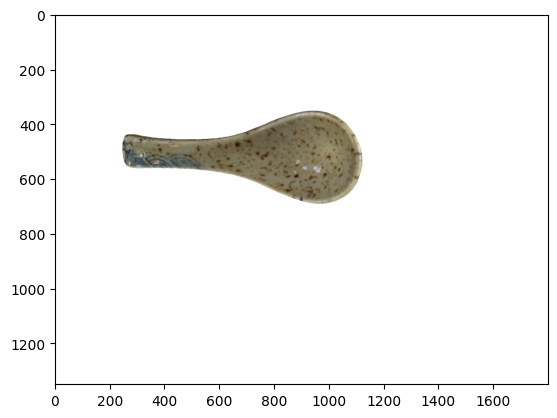

In [7]:
#focus on a single point

scene = trimesh.Scene()
scene.add_geometry(mesh)

point_idx, point_on_mesh = find_nearest_vertex(mesh,data['points_to_contact'][1])
camera_poses = get_camera_poses(mesh, point_index=point_idx, distance=0.2, offset=0.1)
sphere = create_geometry_at_point("sphere", point_on_mesh)
scene.add_geometry(sphere)

# my_cam_transform = get_camera_transform(mesh, point_idx, 0.2)

# print(default_cam_transform)
#set the camera transform and visualize
# scene.camera_transform = my_cam_transform

scene.camera_transform = camera_poses[4]

x = scene.save_image()
# scene.show()
img = Image.open(io.BytesIO(x))
img.save("./test_image.png")
img_arr = np.array(img)
plt.imshow(img_arr)
